In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import math
import itertools
from collections import defaultdict
from operator import itemgetter

import torch
import pandas as pd
# import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import normalize
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from phoneme_lm import PhonemeLM, build_data_loader, build_vocab, encode_pronunciation
from utils import load_data, split_data

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Loading the Data ##

In [4]:
df = load_data(True)
len(df)

124996

In [5]:
phoneme_to_idx, idx_to_phoneme = build_vocab(df.pronunciation.values)
df['phoneme_ids'] = df.pronunciation.apply(lambda pronunciation: encode_pronunciation(pronunciation, phoneme_to_idx))

In [6]:
df['pronunciation_string'] = df.pronunciation.apply(' '.join)
df['length'] = df.pronunciation.apply(len)

In [7]:
train_df, dev_df, test_df = split_data(df, dev_proportion=.2, test_proportion=.01)
len(train_df), len(dev_df), len(test_df)

(98746, 25000, 1250)

## Training the Model ##

In [12]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=20, hidden_dimension=100, num_layers=1,
    max_epochs=2000, early_stopping_rounds=5,
    lr=5e-3, batch_size=1024, l2_strength=0
)


lm.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.6538	assess loss: 1.0123
	 P AH2 R AY2
	 P AW1 AY1 D AH0 N
	 G AA1 K OW2 N
	 OW1 AA0 W W N OW2
	 AY0 EH1 S Z Z
Epoch 2: train loss: 0.5854	assess loss: 0.9075
	 IH0 R AH0 M ER0 D IY2 V EH0 S
	 L ER1 L AH0 L
	 P AO1 R M EY1 SH AH0
	 Y UW1 N T AH0
	 L EH1 JH IH0 V
Epoch 3: train loss: 0.5626	assess loss: 0.8722
	 S IH1 V AE0 V W EH2 R S T
	 Z IH1 CH IH0 D AH0
	 S T IH1 G AH0 T
	 IH0 M IH1 N Y AH0 N
	 Y AE1 T IH0 K S
Epoch 4: train loss: 0.5500	assess loss: 0.8531
	 S AH1 TH EH0 P W UH2 T
	 IH1 AE0 F ER0 N
	 S T UH2 N K AH1
	 P UH1 S IH0 M L IY0
	 R IY1 Z IH0 NG
Epoch 5: train loss: 0.5413	assess loss: 0.8395
	 L AA1 D AH0 Z
	 R AA1 D IH0 F IY0 ER0
	 IH2 N D EH1 L AH0 K IY0
	 T AO1 P ER0 M OW0
	 M AY1 L AH0 N S
Epoch 6: train loss: 0.5349	assess loss: 0.8311
	 G AA1 R AH0 G AH0 L
	 G AA1 L S AH0 L
	 W AY1 D IY0 EY2 T IH0 NG Z
	 HH W AO1 L IY0
	 P IH0 S K AE1 N D IH0 K
Epoch 7: train loss: 0.5297	assess loss: 0.8237
	 S K R IH1 S
	 L EH2 R IH0 TH EH1 N T IH0 D
	 S AY

Epoch 57: train loss: 0.4884	assess loss: 0.7861
	 L AH0 B R AO1 N IY0 OW0
	 S AW1 T EH2 K T
	 G OW1 L T AW2 T
	 S K R AW1 Z
	 B IH1 N Z
Epoch 58: train loss: 0.4886	assess loss: 0.7867
	 M AH0 G EY1 V
	 T EH2 R AH0 P IH1 K T IH0 K
	 B IH1 R IH0 NG T S
	 S L IH1 G AH0 D IH0 Z
	 EY1 K S T R AH2 D IY0
Epoch 59: train loss: 0.4883	assess loss: 0.7870
	 F AY1 ER0 M AH0 N
	 P EY2 UW2 SH UH1 R AH0
	 P R AA2 P L AH0 S EH1 T IH0
	 D ER0 EH1 K T IH0 V L IY0
	 P ER0 S L EY1 Z
Epoch 60: train loss: 0.4882	assess loss: 0.7868
	 S EH1 N JH AH0 N
	 S T AY1 B AH0 L
	 AA1 N S T EY2 K AH0 D
	 B AW1 N D IH0 K
	 D IH0 P L AO1 Z
Epoch 61: train loss: 0.4879	assess loss: 0.7864
	 HH AE1 N D AH0 L Z
	 K AA1 N IY0 P AA2 T S
	 JH EH1 D AH0 L OY0
	 B IY0 HH AH1 M
	 F IH1 NG K S
Epoch 62: train loss: 0.4879	assess loss: 0.7870
	 G AA0 L IY1 N OW0
	 P L IH0 S AA0 M R IY1 SH AH0
	 K AH1 T F IH0 T
	 K AH0 N F EH1 T IH0 SH IH0 NG
	 P R AH0 M IH1 R ER0 Z
Epoch 63: train loss: 0.4877	assess loss: 0.7869
	 D AH1 M ER0

Epoch 112: train loss: 0.4842	assess loss: 0.7881
	 OW0 S L OW1 V AH0 K ER0
	 T W EH1 N D ER0
	 M AO1 S
	 AA1 R B IH0 K L EY2 D
	 M Y UW1 Z ER0
Epoch 113: train loss: 0.4840	assess loss: 0.7878
	 W AO1 R M AH0 N
	 Z UW1 L D
	 EH1 D L AH0 M
	 R IH1 L AH0 V EY2 T
	 S AE1 N Z IH0 Z
Epoch 114: train loss: 0.4838	assess loss: 0.7881
	 K AH0 N T IH1 ZH AH0 N
	 W IH1 T B AH0 L
	 IH0 N D AH0 L IH1 R AH0 N T
	 S EH1 L AH0 N T EY2 L
	 S EH1 L IH0 S
Epoch 115: train loss: 0.4839	assess loss: 0.7880
	 W AO1 L
	 T AY1 NG G OW0 N
	 HH EH1 L AH0 M OW2
	 B IH1 R K R AE2 N T S
	 N UW1 P T
Epoch 116: train loss: 0.4839	assess loss: 0.7884
	 AE2 K AH0 M IY1 N OW0 Z
	 B AE1 G IH0 D
	 S EH1 N T R AO0 F
	 CH IY1 V ER0
	 Y AE1 R AH0 N
Epoch 117: train loss: 0.4838	assess loss: 0.7882
	 T IY1 T AO2 L ER0
	 HH EH1 R AH0 N D L AE2 S
	 CH ER0 K AA1 R Z
	 M AA1 N T IY0 Z
	 M AA1 T L EH0 G AH0 N
Epoch 118: train loss: 0.4906	assess loss: 0.7953
	 K AO1 D Z
	 B Y AE2 K S UW0 S IY1 T IH0
	 D AH0 L AA1 K N IH0 K
	 CH

Epoch 167: train loss: 0.4827	assess loss: 0.7889
	 K IY1 N IH0 G
	 AA0 K Y UW1 IH0 D AH0 N
	 F IH1 S K T ER0
	 OW2 V ER0 W AA1
	 N AE1 SH AH0 N AH0 L AY2 Z IH0
Epoch 168: train loss: 0.4821	assess loss: 0.7883
	 K AO2 Z AH0 N B AA1 L IY0
	 P R IY0 K OW1 S
	 HH IH1 S M AE2 M ER0
	 G R EH1 N B ER0 G
	 AE2 T R IY0 AA1 L AH0 JH IY0
Epoch 169: train loss: 0.4824	assess loss: 0.7887
	 B AH0 N EY1
	 IH1 N AH0 M AH0 S T
	 B Y EH1 N IH0 NG
	 S W EH1 P T
	 W ER1 T L IH0 NG
Epoch 170: train loss: 0.4826	assess loss: 0.7894
	 N OW1 M
	 K IH1 M B AH0 L AY2 Z ER0
	 V AA1 R CH IH0 NG Z
	 L EH1 R IH0 K
	 F L AH1 D M EY2 K ER0
Epoch 171: train loss: 0.4823	assess loss: 0.7891
	 HH AE1 P AH0
	 L AE1 P AH0 L Z
	 B R EY1 B AH0 L
	 P V AE1 L AH0 T
	 M OW1 K AH0 N
Epoch 172: train loss: 0.4824	assess loss: 0.7884
	 AA0 L Y AA1 D AH0
	 CH AO1 K
	 Z EY1 N EY2 D
	 B ER0 T IH1 K IY0
	 SH R IH1 G Z
Epoch 173: train loss: 0.4826	assess loss: 0.7891
	 D EY1 M EH0 DH S
	 SH EY1 T S
	 S T IY1 R OW2 OW2 Z
	 V IH2 D 

Epoch 222: train loss: 0.4813	assess loss: 0.7890
	 P R IY0 F ER1 S ER0
	 R IY0 IH0 M IH1 N IH0 F IY0 N
	 HH IH0 K S P L EH1 N AH0
	 JH EH1 N T AH0 N
	 AH0 N AE1 L AH0 M IY0
Epoch 223: train loss: 0.4811	assess loss: 0.7890
	 R IY2 N AH0 G AE1 N OW2 ER0
	 S IH0 M B OW1 N AH0
	 D IH0 V AA1 V IH0 SH
	 HH IH1 K L EY2 B OW0 D
	 AA1 N AA0 R
Epoch 224: train loss: 0.4815	assess loss: 0.7884
	 F L AE1 K SH ER0 IH0 SH
	 HH AO1 R IH0 NG
	 IY1 S IH0 Z
	 D EH1 L Z
	 HH ER1 IH0 T IH0 D AH0 N
Epoch 225: train loss: 0.4824	assess loss: 0.7901
	 S K EY1 L
	 B EY1 T AH0 N T
	 D AY2 AH0 L IY1 N IY0
	 EH1 K S L ER0
	 T AA1 L Z IH0 NG
Epoch 226: train loss: 0.4816	assess loss: 0.7889
	 F L AE1 M ER0 IY0 Z
	 AH0 N B EH1 N K IY0
	 K AO2 R CH IY0 EH1 N
	 L AE1 N D G AO2 R N
	 B R AY1 ER0 Z
Epoch 227: train loss: 0.4814	assess loss: 0.7893
	 K EH1 R IH0 K
	 EH1 P IY0
	 T AE2 L AH0 B IY2 T AE1 L AH0
	 AA1 R V IH0 S
	 B AA1 P T IH0 SH
Epoch 228: train loss: 0.4816	assess loss: 0.7891
	 D IH0 Z EH1 T
	 M IH1 L 

Epoch 277: train loss: 0.4817	assess loss: 0.7909
	 M EH1 D AH0 L IH0 T IH0 S
	 IH0 M V AA1 N D ER0 Z
	 P AA1 R D AH0 N
	 B EH2 R EH1 S IH0 V AH0
	 L IH1 K
Epoch 278: train loss: 0.4811	assess loss: 0.7886
	 K W ER1 Z AH0
	 TH AO2 R M AE1 N T AH0
	 AH0 N T R IH1 G ER0 SH AH0 B
	 W EH1 S N ER0
	 T R EH1 NG L AH0 S EY1 Z
Epoch 279: train loss: 0.4812	assess loss: 0.7898
	 P AA0 R EH1 L AH0
	 G R IY1 V IH0 N
	 R OY1 D ER0 Z
	 AW0 T V W OW1 Z
	 S AH0 B K EH1 R IH0 SH
Epoch 280: train loss: 0.4810	assess loss: 0.7899
	 R AY1 D AH0 N Z
	 B R EH1 D K ER0 IH0 NG
	 B L AH1 JH M AH0 N EH2 L IY0
	 HH AA1 P M AH0 N
	 R AH1 JH IH0 K
Epoch 281: train loss: 0.4812	assess loss: 0.7904
	 S W EY1 D R IY0 Z
	 L AY0 K OW1 N IY0 AH0 S
	 K AA1 R IY0
	 AA1 K S AH0 K AH0 T
	 T AA1 G P
Epoch 282: train loss: 0.4816	assess loss: 0.7909
	 K R IH1 K ER0
	 IH0 M Y UW1 N IH0 S T
	 K AA1 M IH0 R
	 S EH1 D R AH0
	 K AA1 P IH0 N AH0
Epoch 283: train loss: 0.4817	assess loss: 0.7905
	 M AH0 K V EY1 AH0 N
	 G L UW1 AH0 

Epoch 334: train loss: 0.4808	assess loss: 0.7894
	 L AE1 T IH0 N
	 Z AH0 S T R IH1 NG K IY0
	 EH0 M P AA1 L M AH0 T IH0 V
	 EH1 K Y AH0 L IH0 N
	 EH1 M P T
Epoch 335: train loss: 0.4808	assess loss: 0.7902
	 F EH1 L IH0 F IY2 L D
	 P ER1 AH0 N Z
	 EH1 NG M AH0 N
	 IY1 M AH0 N
	 B AH1 N IY0
Epoch 336: train loss: 0.4804	assess loss: 0.7898
	 R OW1 Z M AH0 N
	 D AH1 G AH0 L D
	 S L EY1 M AA0 R
	 K OW2 L EH0 V OW0 N EY1 Z IY0
	 Y UW2 SH AH0 L OW1 N
Epoch 337: train loss: 0.4808	assess loss: 0.7902
	 S T EY1 P S
	 HH AA1 S AH0 N
	 S UW1 SH
	 CH AE1 V ER0 IY0
	 EY1 L AH0 K
Epoch 338: train loss: 0.4812	assess loss: 0.7905
	 AH2 N D AH0 T IH1 M B OW0
	 IH0 N HH AH1 L S AH0 N
	 F AH0 T EH1 L IH0 F
	 B EH1 N IH0 NG
	 S EH1 L IY0
Epoch 339: train loss: 0.4811	assess loss: 0.7903
	 P EH1 R AH0 L
	 R AH0 F AO1 R S IH0 T
	 D IH0 V AO1 R Z AH0 Z
	 SH OW0 NG G R EY1 V AH0 L
	 D EH1 NG K
Epoch 340: train loss: 0.4813	assess loss: 0.7905
	 F AO1 R F AY2 D
	 JH AH1 NG G AH0 L Z
	 S ER1 N IY0
	 K ER0 A

KeyboardInterrupt: 

In [15]:
%%time

lm2 = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=20, hidden_dimension=100, num_layers=1,
    max_epochs=2000, early_stopping_rounds=3,
    lr=5e-3, batch_size=1024, l2_strength=0
)


lm2.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.6749	assess loss: 1.0454
	 IH0 P R D IH0 S
	 M L T
	 M AE1 P AW1 AH0 L EY2 F L ER0
	 D IH0 T AH0 N
	 B ER0
Epoch 2: train loss: 0.5855	assess loss: 0.9070
	 EH1 T S AH0
	 JH IH1 M IH0 K
	 S AE1 N SH AH0 S ER0
	 M EH1 P EH2 Z IH0 N IH0 JH IY0
	 R AW1 G ER0
Epoch 3: train loss: 0.5623	assess loss: 0.8710
	 P AY1 V N AH0 M IH0 N
	 OW2 N OW1
	 P EH2 M AA1 L M AH0 N
	 B UW0 L AE1 P AH0 L EY2 T IY0
	 K S EH1 K K EY0
Epoch 4: train loss: 0.5499	assess loss: 0.8522
	 EH2 N S IY0 Z IH0 G IH1 R IY0
	 CH AH1 S B AH0 L
	 S EH1 S AH0 K SH
	 M IY1 W EY1 B R AA2 T
	 B EH1 L N AH0 N
Epoch 5: train loss: 0.5417	assess loss: 0.8411
	 R IH0 M P L AA1 K S T AH0
	 G EY1 P ER0 TH
	 M IY1 T AH0
	 HH OW1 L IH0 NG
	 S AY1 JH AH0 TH
Epoch 6: train loss: 0.5352	assess loss: 0.8310
	 S T R IY1 F
	 SH ER1 B IH0 N
	 M UW0 T IY1 N
	 IH0 N K ER1 P T
	 K R AW1 TH
Epoch 7: train loss: 0.5303	assess loss: 0.8251
	 HH OW1 N
	 T AE2 M IH0 F UW1 Z AH0 M
	 IH0 K S P AY1 D ER0
	 D AE1 SH ER0
	 P R ER0 

Epoch 56: train loss: 0.4889	assess loss: 0.7874
	 T AO0 R IY1 D AH0
	 S IY1 K AA2 N S
	 T R AH1 S K IY0
	 S T IH1 D IY0 AH0
	 T EH2 R AH0 N T IY1 N IH0 K
Epoch 57: train loss: 0.4885	assess loss: 0.7859
	 SH IH1 L ER0 JH AW2 N
	 OW1 B AH0 K AA0 P
	 M R EY1 T OW0
	 T R AH1 S T ER0
	 K AA2 M P ER0 HH IH1 N AH0 T
Epoch 58: train loss: 0.4887	assess loss: 0.7869
	 R IH1 SH M AH0 N
	 S T ER1 S AH0 N
	 P L EH2 N IH0 M AE1 T ER0 AH0
	 AE1 L V IY0
	 S AH0 K AO2 R IY0 EH1 Z IH0 K
Epoch 59: train loss: 0.4884	assess loss: 0.7865
	 K AH0 S AO1 D UW0
	 ER1 B IH0 T EY0 N
	 K AO1 R M AH0 N
	 W IH1 L AH0 B OW2 Z EY1 SH
	 AH2 N S AH0 F IH1 K Y UW0 L
Epoch 60: train loss: 0.4887	assess loss: 0.7872
	 AO1 K IY0
	 AH0 K EH1 N T ER0 AH0
	 JH OY1 AH0 L Z
	 S T EH1 P T
	 K L IY1 N AH0 G
Epoch 61: train loss: 0.4880	assess loss: 0.7872
	 M AY1 K ER0 S AH0 L T
	 EH1 R K AA2 R D
	 B R AH0 S UW1 D
	 D EH1 F AH0 S AH0 NG Z
	 SH AY1 D OW0
Epoch 62: train loss: 0.4882	assess loss: 0.7876
	 B L EH1 N D
	 IY1 D AO0

Epoch 112: train loss: 0.4841	assess loss: 0.7886
	 S T EH1 D M AH0 N
	 AH2 N K AH0 N F R EH2 S N
	 G R IH0 M EH1 N S K IY0
	 W IH1 G IH0 N
	 AH0 K W EH0 L T S EH1 L IY0
Epoch 113: train loss: 0.4844	assess loss: 0.7888
	 M AA0 S EH0 K AH0 N R AA1 N
	 D OW1 N AH0
	 AO0 S IY1 L EY0
	 M IY1 L IY0 AH0 M
	 P AW1 N ER0
Epoch 114: train loss: 0.4839	assess loss: 0.7882
	 S IH1 N T R EY2 V
	 L EH1 TH AH0 N
	 W ER1 T AH0 N IY0 ER0 Z
	 HH OW1 P AH0 N Z
	 IH0 R IH1 NG L IY0
Epoch 115: train loss: 0.4840	assess loss: 0.7880
	 R OW1 L
	 K R IY1 S T
	 S W IY1 T IH0 JH
	 D IH0 L IH1 Z W ER2 DH
	 B EH0 R IY1 N
Epoch 116: train loss: 0.4839	assess loss: 0.7877
	 M EY0 N JH EH1 T AH0
	 JH AE1 N IH0 K
	 S T AA1 R K L AE2 T S
	 D EH1 L ER0 IH0 N
	 D IH0 T S UW1 S AH0 N Z
Epoch 117: train loss: 0.4845	assess loss: 0.7892
	 AA0 R AA0 K EH1 L AH0
	 M AH0 K AE1 L AH0 F IY2 L ER0
	 R AA1 Z AH0 D IH2 K
	 S T EH1 N
	 S EH0 N T R AH1 SH AH0 N AH0
Epoch 118: train loss: 0.4837	assess loss: 0.7885
	 M AO1 R IH0 JH

Early stopping because of no decrease in 3 epochs.


([0.6749151945114136,
  0.5855262279510498,
  0.5622522830963135,
  0.5498712062835693,
  0.5417002439498901,
  0.5352427959442139,
  0.5302697420120239,
  0.5263610482215881,
  0.5229458808898926,
  0.520345151424408,
  0.517869234085083,
  0.5154879093170166,
  0.5135108828544617,
  0.5117155313491821,
  0.5103448033332825,
  0.5091380476951599,
  0.5075637698173523,
  0.5063316226005554,
  0.5053435564041138,
  0.504071831703186,
  0.5032092332839966,
  0.5023142695426941,
  0.5016072392463684,
  0.5007343292236328,
  0.499866783618927,
  0.49923327565193176,
  0.4988352060317993,
  0.49779894948005676,
  0.4976766109466553,
  0.49751052260398865,
  0.496646523475647,
  0.49575307965278625,
  0.49547910690307617,
  0.4950869679450989,
  0.49474018812179565,
  0.4942973256111145,
  0.4937548041343689,
  0.4938803017139435,
  0.4932725429534912,
  0.49338674545288086,
  0.49233517050743103,
  0.49273762106895447,
  0.49179479479789734,
  0.49180173873901367,
  0.491182416677475,
  0.4

In [16]:
train_losses_2, dev_losses_2 = _15

[0.4828657805919647, 0.48299720883369446, 0.4830719232559204]
[0.7882837653160095, 0.7888554334640503, 0.7885197997093201]


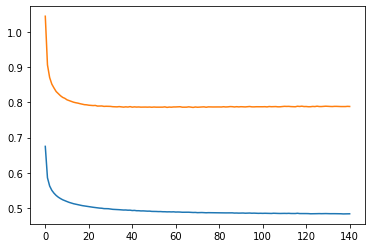

In [19]:
plt.plot(train_losses_2)
plt.plot(dev_losses_2)

print(train_losses_2[-3:])
print(dev_losses_2[-3:])

In [20]:
%%time

lm3 = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=20, hidden_dimension=100, num_layers=1,
    max_epochs=2000, early_stopping_rounds=3,
    lr=5e-3, batch_size=1024, l2_strength=1e-3
)


train_losses_3, dev_losses_3 = lm3.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.7020	assess loss: 1.0858
	 F R G M N AH0 IH0 Z D IH0
	 R F AE1 N T D ER0 T
	 L L L L AH0 L R
	 G IH0 S F S Z
	 K EH0 P
Epoch 2: train loss: 0.6500	assess loss: 1.0064
	 K IY0 G R OW1 M ER0
	 TH OW0 P EY1 IY0 Z S
	 P AH1 AH0 N
	 HH AH0 L V
	 EH1 D AH0 L ER1
Epoch 3: train loss: 0.6263	assess loss: 0.9698
	 K L EH1 AH0 N S AH0 T OW1 N
	 B EH1 L IH0 K K
	 NG OW2 N IH0 S T AH1
	 M EH1 L K Z
	 B ER0 N AO0 IH1 B ER0
Epoch 4: train loss: 0.6150	assess loss: 0.9518
	 K EH1 R IY0 AH0 N
	 AW0 AO2 N T Z
	 IH1 S T EH2
	 F AH0 B AY2 K AE1 N T Z
	 K EH1 N S AH0
Epoch 5: train loss: 0.6086	assess loss: 0.9422
	 L ZH EH1 N Z
	 N M N V AY0 NG
	 M R SH AA1 B Z IH0 AH0 N
	 K R T AE0 CH IY0
	 AE1 EH0 P
Epoch 6: train loss: 0.6062	assess loss: 0.9386
	 B IH1 L AH0 S IH0 N
	 S EH1 EH0 T Y OW0
	 R AY1 T M
	 M EH1 N AH0 T AH0 L
	 T AA1 N TH EH2 L D EY2
Epoch 7: train loss: 0.6056	assess loss: 0.9370
	 F W EY1 T IY0
	 JH AE1 K D G R EY2 S
	 R AH1 S T OW2 EY2 T IH0 UW0 IY0
	 W T EY1 N D I

Epoch 56: train loss: 0.6036	assess loss: 0.9345
	 L AE1 NG D AH0 L
	 M AO1 R AH0
	 AY2 T L Z Y AA1 N IY0 SH
	 T AO1 L B R
	 R ER1 T IY0 IY0
Epoch 57: train loss: 0.6032	assess loss: 0.9333
	 W ER1 W AO1 B M K R D
	 AH0 P EY1 N IH0 K
	 P TH JH Y AH0 S IH1 R K AH0
	 D IH1 L Z AH0 L Z
	 D AH0 N G R EY1 N
Epoch 58: train loss: 0.6033	assess loss: 0.9340
	 R EH0 T R AO0 M IH0 T W EY1
	 K EH0 R S AA1 S
	 L AH0 N IY0 N OW0 S IH1 D AH0
	 S AA1 AH0 N K AH0 N
	 IH0 M N EH1 TH S Z B ER2
Epoch 59: train loss: 0.6039	assess loss: 0.9355
	 IH0 M AA1 EH1 V AA1 L
	 Y K S L AH1 N AA1 F IY0 AY0
	 T R IY0 OW0 S D EH1 V
	 <W> K EY1 L IY0
	 S K F OW1 P W M IY0 OW0
Epoch 60: train loss: 0.6034	assess loss: 0.9338
	 F UH1 Z D AH0 N Z
	 L AA1 B D AH0 D AH0 S N
	 R EH1 N IY0
	 HH AA1 IH2 N K S
	 G N EY1 N IH0 T
Epoch 61: train loss: 0.6040	assess loss: 0.9347
	 SH UW L T AH0 L UW1 R AH0
	 P R AE1 V IY0
	 EH1 AA0 IH0 S T AH0 L D AY1
	 T AH1 R
	 S IY1 L D
Epoch 62: train loss: 0.6037	assess loss: 0.9345
	 K IH0

Early stopping because of no decrease in 3 epochs.


[0.6036767363548279, 0.6044787168502808, 0.604854941368103]
[0.9347949028015137, 0.9360793232917786, 0.9355281591415405]


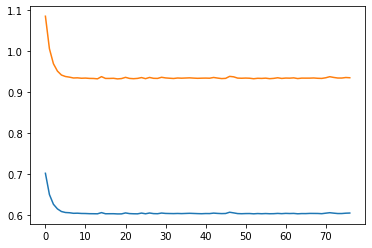

In [21]:
plt.plot(train_losses_3)
plt.plot(dev_losses_3)

print(train_losses_3[-3:])
print(dev_losses_3[-3:])

In [22]:
%%time

lm4 = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=20, hidden_dimension=100, num_layers=1,
    max_epochs=2000, early_stopping_rounds=3,
    lr=5e-3, batch_size=1024, l2_strength=1e-5
)


train_losses_4, dev_losses_4 = lm4.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.6740	assess loss: 1.0443
	 AA1 T JH AY2 EH1
	 AA1 HH AH0 T T S
	 K P M IY0 Z
	 IH1 S EH1 S AO1 L
	 K IH0 D M P T
Epoch 2: train loss: 0.5945	assess loss: 0.9208
	 S R IH1 G ER0 AH0 N
	 L AA1 D T B
	 AH0 NG T EY1 V IH0 K
	 M AA1 T IY0 ER0
	 L AY1 IH0 S T IH0 T
Epoch 3: train loss: 0.5665	assess loss: 0.8782
	 P AA1 R ER0
	 N IH1 R IH0 NG T
	 SH IH1 S T AA0 CH
	 S IY0 AH0 N IH1 G N IY0 ER0
	 P AH1 F
Epoch 4: train loss: 0.5531	assess loss: 0.8581
	 D EH1 S R AH0 N
	 Y AH1 F AH0 N CH EH0 R
	 HH AE1 JH AH0 N
	 JH AA2 NG T AH0 JH AH0
	 AA2 N AE1 L
Epoch 5: train loss: 0.5441	assess loss: 0.8445
	 B AA1 R S AH0
	 K R EH1 N OY2 M AH0 F
	 G AA0 L T OY1 IH0 NG
	 P R EY1 S AH0 Z AH0 N
	 F OW1 B IY0 N
Epoch 6: train loss: 0.5378	assess loss: 0.8350
	 P R AY2 P AH0 G IH1 M AH0 T
	 HH AE1 L IH0 K S
	 K R OW1 S IH0 T S
	 F Z UW1 S B AA2 R D
	 W AE1 N OW0
Epoch 7: train loss: 0.5332	assess loss: 0.8282
	 B R EH1 N IH0 NG
	 B AE1 R IY0
	 R AO1 R L D
	 P R IY0 AH0 P Y AA1 Z IH0 N

Epoch 57: train loss: 0.4934	assess loss: 0.7830
	 V AE0 N AE1 D IH0 S
	 AO1 K D IH0 S AH0 N
	 D ER1 D IY0
	 K R EY1 D L IY0
	 P IY1 T S
Epoch 58: train loss: 0.4932	assess loss: 0.7825
	 P AA1 R P S
	 R AA1 M IH0 NG HH AY2 R
	 G R EH1 N T AH0 N
	 M AA0 R UW1 N
	 HH OW1 Z
Epoch 59: train loss: 0.4929	assess loss: 0.7828
	 AH0 P L AY1 R IY0 Z
	 S T AA1 R T S T
	 M IH1 N S K AH0 T
	 Z IH1 S K
	 L ER0 AA1 K
Epoch 60: train loss: 0.4931	assess loss: 0.7831
	 T IH1 SH
	 K AE1 L IY0 N AH0 S
	 S T EH1 F ER0 N
	 T AE1 L ER0
	 T R AE0 N T IY1 N AH0
Epoch 61: train loss: 0.4925	assess loss: 0.7822
	 K IY1 P ER0
	 W ER1 K
	 AE1 R AH0
	 EH1 G Z B AY2 L
	 HH AO1 M B AH0
Epoch 62: train loss: 0.4925	assess loss: 0.7826
	 S AH1 D N EH2 K T ER0
	 R UW1 N IH0 NG
	 G Y UW0 N AA0 Z OW1 N
	 AE1 S T AH0 L ER0
	 K L AH1 K
Epoch 63: train loss: 0.4921	assess loss: 0.7821
	 L IH0 P AO1 N IY0 OW0
	 P EY1 T
	 R IH0 K AA1 N IH0 K
	 B AY1 AH0 T ER0 Z
	 D ER0 IY1 AA0 N Z
Epoch 64: train loss: 0.4923	assess loss: 0

Early stopping because of no decrease in 3 epochs.


[0.489040344953537, 0.48917627334594727, 0.4892515540122986]
[0.7805904746055603, 0.7806904911994934, 0.7810698747634888]


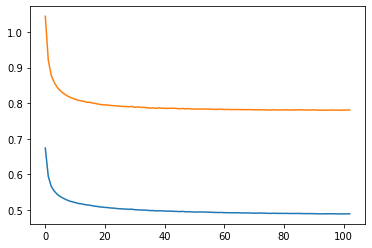

In [23]:
plt.plot(train_losses_4)
plt.plot(dev_losses_4)

print(train_losses_4[-3:])
print(dev_losses_4[-3:])

In [24]:
%%time

lm5 = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=20, hidden_dimension=100, num_layers=1,
    max_epochs=2000, early_stopping_rounds=3,
    lr=5e-3, batch_size=1024, l2_strength=5e-4
)


train_losses_5, dev_losses_5 = lm5.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.6684	assess loss: 1.0354
	 G L P T P IH0 N AH0 L Z
	 W L EY2 T M T
	 L AE1 R
	 B N V AH0 N D EH2
	 CH B L IY0 V
Epoch 2: train loss: 0.6163	assess loss: 0.9544
	 EH1 UW1 ER0
	 R EY1 K AH0 N IH0 NG ER0
	 SH AE1 D AH0 N IY0
	 SH AO1 L AH0 K
	 HH P L
Epoch 3: train loss: 0.5967	assess loss: 0.9236
	 CH AH0 S T AE1 S Z
	 K EY1 L AH0 N
	 B AE1 K P SH IY0
	 AY1 Z IY0
	 EY1 P T IY1 T AH0 T
Epoch 4: train loss: 0.5894	assess loss: 0.9119
	 K AO1 L ER0
	 T AA1 S S N AE2 K
	 K R W EY1 T AH0 S B
	 M AA1 G AY0 IH0 NG
	 OW0 L AE1 S K ER0 T IY0 T ER0
Epoch 5: train loss: 0.5864	assess loss: 0.9077
	 K R AA1 K CH IH0 NG
	 K AH0 K R IH1 S T AH0 L
	 F AH1 T D ER0
	 SH EH1 N IY0
	 AW2 N M R IY1 K Z
Epoch 6: train loss: 0.5849	assess loss: 0.9054
	 EH2 M AH0 N AO1 OY1
	 S T S IY1 M SH EY0 NG
	 AH0 M AE1 L AH0 Y IY0
	 N L IY1 T IY0 Z
	 B ER0 L EH1 K JH ER0
Epoch 7: train loss: 0.5830	assess loss: 0.9024
	 T ER0 P EH1 R D AH0
	 P AA2 L T UW2 N
	 AE1 V ER0 T S K AH0 F IY0
	 G L AH2 G 

Epoch 57: train loss: 0.5778	assess loss: 0.8948
	 AA1 M AH0 L IH1
	 S AH1 D IH0 N AH0
	 V UH1 D S AH0 S ER0
	 V AA1 L D
	 EY0 M EH1 L D ER0
Epoch 58: train loss: 0.5769	assess loss: 0.8938
	 F N UW1 NG K
	 D AA1 M HH AH1 T ER0
	 K AY1 T ER0
	 D B OW1 S K IY0
	 N EH0 B AE1 N Z
Epoch 59: train loss: 0.5771	assess loss: 0.8937
	 JH AE1 L IH0 NG
	 D OW1 N K L AE2 M
	 JH L AE1 K Y AE2 Z
	 OY2 EH1 N D IH0 S T
	 S N R EH1 F T AH0 S
Epoch 60: train loss: 0.5765	assess loss: 0.8931
	 F AE1 N ER0 G OW1
	 N AA1 S B R IY0
	 T EY1 L IY0
	 S AH0 JH L IY1
	 K AH0 L M IH1 S T ER0
Epoch 61: train loss: 0.5765	assess loss: 0.8929
	 K AA1 R N AH0 K
	 M EH1 N T IY2 ER0
	 K EY1 S L IY0
	 F IH1 NG K Y IY2 T S
	 S AE1 N R ER0 SH EY0
Epoch 62: train loss: 0.5770	assess loss: 0.8939
	 Y IH1 K S Z AH0 N
	 K AY1 M AH0 N
	 M AA1 Z OW0 ER0
	 D AE2 M B AH0 D AA0 K S
	 W IY0 AO1 R AH0
Epoch 63: train loss: 0.5772	assess loss: 0.8941
	 W OW0 ZH IY1
	 AO1 AO1 T OW0
	 M IY0 IH1 N B ER0 T F AH0 N
	 D EH0 IH1 K AH0 S EY

Early stopping because of no decrease in 3 epochs.


[0.5770877599716187, 0.5773670673370361, 0.5776652693748474]
[0.8941097259521484, 0.8934898972511292, 0.8951695561408997]


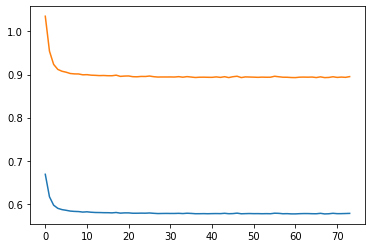

In [28]:
plt.plot(train_losses_5)
plt.plot(dev_losses_5)

print(train_losses_5[-3:])
print(dev_losses_5[-3:])

In [29]:
%%time

lm6 = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=20, hidden_dimension=100, num_layers=1,
    max_epochs=2000, early_stopping_rounds=3,
    lr=5e-3, batch_size=1024, dropout=.5,
)


train_losses_6, dev_losses_6 = lm6.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.6685	assess loss: 1.0346
	 IH2 AY1 S UW2
	 P R AE1 S
	 SH UW1 IY1 K
	 EH1 AO1
	 EH1 B AH0 EH1 L IY0
Epoch 2: train loss: 0.5903	assess loss: 0.9143
	 D ER1 V AH0 S
	 IH1 R T R IY0 ER0 Z
	 N JH AO1 L S
	 M AA1 N IH0 K D ER0
	 Y AE1 L TH AH0 S
Epoch 3: train loss: 0.5719	assess loss: 0.8863
	 V EH0 M G R AO1 F IY0
	 L AO1 M AH0 L AH0 L D
	 
	 HH P R IY0 Y UW1
	 W IY1 L IH0 D
Epoch 4: train loss: 0.5621	assess loss: 0.8713
	 P IY0 K OW1 G OW0
	 S AA1 L Y OW0
	 D OW1 S T AH0 N
	 R EH1 D AH0 L AH0 M D
	 M AA2 CH AE1 N
Epoch 5: train loss: 0.5549	assess loss: 0.8605
	 V AA2 R UW0 IH1 JH AH0 R IH2 K
	 W ER1 P Z
	 G R OW2 S T IY1 N IY0 HH EY2
	 S AW1 UW2 K IY0
	 N AE1 Z M AH0 N Z
Epoch 6: train loss: 0.5502	assess loss: 0.8530
	 T IH1 L P IH0 NG
	 CH AA1 D ER0
	 AH0 B EY1 P IY0
	 JH AE1 B IY0 Y IY0
	 HH AO1 N D ER0
Epoch 7: train loss: 0.5462	assess loss: 0.8475
	 D IH1 D AH0
	 D IY1 F ER0
	 K AH0 M IH1 N K T IY0
	 IY0 AH0 F Y IH1 R AH0 N F AH0
	 F R IH1 S M
Epoch 8: tra

Epoch 57: train loss: 0.5100	assess loss: 0.8015
	 T R IH1 K AH0 N
	 K EH1 N V AH0 Z OW2 M
	 K AH0 N T EH1 N D IH0 D
	 M AW1 T ER0
	 EH0 K S P EH1 L IH0 K AH0 L
Epoch 58: train loss: 0.5099	assess loss: 0.8006
	 M AH0 K L EH1 NG S F IY0
	 V IY1 ZH ER0
	 K EH1 R D UW2
	 M UW1 D AH0 N
	 F AO1 R CH
Epoch 59: train loss: 0.5097	assess loss: 0.8009
	 AH0 M AA1 T IH0 NG S AH0 N
	 G ER1 K IH0 NG
	 F ER0 M IH1 L AH0 S
	 B IY1 AH0 L
	 L AH0 K R AO1
Epoch 60: train loss: 0.5093	assess loss: 0.8003
	 R UW1 S AO0 R T S
	 T AA1 T AH0 K
	 B AA1 L D
	 L EH0 L IH0 V EH1 L
	 B EY1 P
Epoch 61: train loss: 0.5092	assess loss: 0.8002
	 L AE1 R S IH0 D
	 Y UW1 L IY0
	 HH IH1 M N ER0
	 K AA1 B L IH0 T S
	 W AO1 G ER0
Epoch 62: train loss: 0.5092	assess loss: 0.8002
	 B UW1 L IY0 AH0 S T
	 AH0 V ER0 S T EH1 B Y AH0 T
	 IH2 N AH0 B EH1 K T EH2 D
	 K EH0 L IY1 N AH0
	 B AE1 N AH0 T
Epoch 63: train loss: 0.5088	assess loss: 0.7998
	 K AA1 K
	 G IY1 N ER0 IY0
	 B AH1 R HH AO2 R Z
	 T OW1 V AH0 T
	 K AE2 N S AH0 

Early stopping because of no decrease in 3 epochs.


[0.5055629014968872, 0.5056354999542236, 0.5058738589286804]
[0.7979589700698853, 0.7983555197715759, 0.7982129454612732]


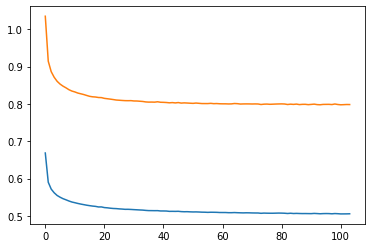

In [30]:
plt.plot(train_losses_6)
plt.plot(dev_losses_6)

print(train_losses_6[-3:])
print(dev_losses_6[-3:])

In [31]:
%%time

lm7 = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=20, hidden_dimension=100, num_layers=1,
    max_epochs=2000, early_stopping_rounds=3,
    lr=5e-3, batch_size=1024, dropout=.9,
)


train_losses_7, dev_losses_7 = lm7.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.6921	assess loss: 1.0724
	 AH0 R D
	 AH1 V S N AE1 AH0
	 CH IH1 P AE2
	 P OW1 Z IY1 D L NG
	 AH0 R N AA1 IH0 R
Epoch 2: train loss: 0.6244	assess loss: 0.9669
	 K UW1 M AA0 N
	 S AA1 B
	 M IH1 N B F ER0 AH0 Z
	 S K IY1 Z ER0 D
	 AY0 OW2 L IH1 P NG
Epoch 3: train loss: 0.6083	assess loss: 0.9423
	 L AW1 T K OW0
	 R IH1 T AH0 N
	 HH IH1 M ER0 P
	 OW2 K IH1 S
	 IH0 S M IH1 B ER0
Epoch 4: train loss: 0.6002	assess loss: 0.9290
	 CH AA1 N AA2 K N
	 L P IH1 K AH0 N
	 IH0 N W AA1 R N Z
	 R IY1 M T M R IY2
	 B W AW1 B B ER0 Z
Epoch 5: train loss: 0.5940	assess loss: 0.9198
	 S EH2 W IH2 V T F ER0 S ER0
	 G ER1 T ER0
	 K UW1 Z IH0 NG
	 T AE1 S P
	 AO1 N SH AH0 N IH0 K
Epoch 6: train loss: 0.5902	assess loss: 0.9143
	 Z M EH1 L Z IH0 T
	 B AH0 V EY1 P IH0 CH AH0 N
	 EH1 R IH0 N
	 D AA2 S D AH2 P ER0 L EH1 N
	 K AE1 T IY0
Epoch 7: train loss: 0.5873	assess loss: 0.9104
	 T Y ER1 N K L IY2
	 L EY1 V IY2 Z
	 UW1 V AH0 P
	 L OW1 T
	 L AO0 R HH EY1 R IY0
Epoch 8: train loss: 0.

Epoch 57: train loss: 0.5601	assess loss: 0.8694
	 AE2 K EH0 L AA1 N
	 G EH1 N AH0 S ER0
	 B EY1 D
	 D AH1 M N IH0 P
	 D AY0 W EH1
Epoch 58: train loss: 0.5595	assess loss: 0.8682
	 V AA1 N TH ER0 JH EH0 N Z
	 B R IH1 G AH0 N
	 Y AH1 G OW0
	 T EH1 L AY0 R AH0 N T Z
	 T IY1 T ER0
Epoch 59: train loss: 0.5606	assess loss: 0.8699
	 IH0 L D AE0 G D EH1 N Y AH0
	 M AE2 D AH0 K ER1 T IY0
	 UH0 TH EY1 IY0 AH0
	 S Z ER1 M AH0 S
	 G ER2 P
Epoch 60: train loss: 0.5587	assess loss: 0.8673
	 SH EH1 N Z
	 L AE1 S D AH0 N
	 AH1 M F IH0 TH
	 K AH2 L T AY0 AA1 HH IH0 T
	 SH AH1 K S
Epoch 61: train loss: 0.5600	assess loss: 0.8692
	 G ER0 OW1 B AH0
	 HH AA1 N AH0
	 K L AA2 N OW0 N AH1 D AH0 T
	 R OW1 JH IH0 R AH0 N
	 R AA1 G N IY0
Epoch 62: train loss: 0.5588	assess loss: 0.8671
	 B EH1 N OW0 S
	 B IH1 K AE0 L
	 R AE1 M AY0 T Z
	 S IH1 R AH0 M D
	 S AA1 S L IH0 N
Epoch 63: train loss: 0.5596	assess loss: 0.8688
	 M IH1 P ER0 L ER0
	 M AA1 K AH0 V IH0 N
	 D OW1 P IH0 M
	 L IH1 V IH0 L
	 K AH0 B R AH0 K 

Early stopping because of no decrease in 3 epochs.


In [33]:
encode_pronunciation(['F', 'IH1', 'SH'], lm.phoneme_to_idx)

array([ 1, 51, 55, 37,  2])

In [34]:
%%time

lm8 = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=100, hidden_dimension=10, num_layers=1,
    max_epochs=2000, early_stopping_rounds=3,
    lr=5e-3, batch_size=1024,
)


train_losses_8, dev_losses_8 = lm8.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.8192	assess loss: 1.2317
	 AE1
	 ER0 UH1 EH1 R UH2 B
	 Z ER0
	 
	 B EY1 S D V ER1 AH1 AH0
Epoch 2: train loss: 0.7273	assess loss: 1.1131
	 UW1 T AH0
	 F SH D OY1 M IY0 Z L HH M
	 AE1 ER0 IY1
	 S AO0 B AO2 S AH0
	 IH0 R AO1 IY0 IY1
Epoch 3: train loss: 0.6802	assess loss: 1.0463
	 IY1 S AH0 EH1 B UW2 AA1 S T S
	 D AA1 R L
	 B AH0 S AO1 R D CH IH0 Z
	 EH1 HH S AA0 T ER1 HH D
	 T AA2 R M IY0
Epoch 4: train loss: 0.6494	assess loss: 1.0008
	 S W AA1 JH T
	 Z TH UW AH0 D T AH0 R
	 OW1 EH1 N K
	 T ER0 D AH0 R ER2 SH
	 B EH1 R OW0
Epoch 5: train loss: 0.6308	assess loss: 0.9737
	 S IH0 K K AW1 N IY1 NG T Z
	 IY1 P AH0 K IH1 UW G AW2 G
	 SH R EY1 M
	 K AH1 S L AH0 F
	 SH AO1 R IH0 T SH Y IY0 AA0 L
Epoch 6: train loss: 0.6187	assess loss: 0.9562
	 S IH0 S AE1 Y NG AE0 N IH0 D
	 OW1 AY1 Z
	 SH B EH1 L IH0 N
	 OW2 SH G AA1 V AH0 SH B ER0
	 M W IY2 S AO1 R IY0 AH0 T
Epoch 7: train loss: 0.6100	assess loss: 0.9432
	 S Z OW1 D
	 T UW1 M AH0 B
	 B R IH1 S P IY0 IH0 M
	 AY1 IY0

Epoch 56: train loss: 0.5625	assess loss: 0.8728
	 R IH1 S K AH0 T IH0 S
	 AH0 B L G AH1 NG AH0 S
	 K AE1 F R AA2 L
	 ER0 ER0 AY0 B EH0 L CH OW0 P L
	 K OW1 D OW0 M EY2
Epoch 57: train loss: 0.5622	assess loss: 0.8721
	 OW0 M EH1 DH ER0
	 S T AW1 SH EH2 G
	 P EY1 M OW0
	 T OW1 N S T AH0 D AY2 ER0
	 IY0 K ER1 S AH0 L W EH2 D S
Epoch 58: train loss: 0.5621	assess loss: 0.8711
	 SH AY1 AH0 N ER0 IY0
	 L UW1 D T IY1
	 SH AO1 R T K AH0
	 R AE1 L AH0 N
	 HH AW1 HH AH0 JH
Epoch 59: train loss: 0.5616	assess loss: 0.8706
	 V AH0 K R AA1 N IH0 NG
	 K AH1 N D F ER0 N
	 AE2 M P UH1 CH
	 Y AH1 N S P IH0 K
	 W EH1 D N V ER0 Z
Epoch 60: train loss: 0.5621	assess loss: 0.8718
	 B ER1 L B AH0 Z ER0
	 HH AE1 N T AH0 R AH0 M
	 AA0 T AE1 F IH0 Z IY0 Z AY2 V
	 L OW0 B ER1 AH0 N
	 AA0 L IH1 N D
Epoch 61: train loss: 0.5615	assess loss: 0.8709
	 M UW1 S EH0 N
	 SH AO1 R TH AH0 S AY2 Z
	 S P OW1 N
	 L EY1 S T IH0 NG
	 L EH1 G AH0 L IY0
Epoch 62: train loss: 0.5614	assess loss: 0.8706
	 AA1 R S T R EH2 HH AH0

Epoch 112: train loss: 0.5567	assess loss: 0.8632
	 K UW1 N IH0 JH ER0
	 N ER1 D AH0 K IY0 AH0 N
	 M AO1 R D AH0 L IY0
	 T EH1 SH AH0 N
	 D EH1 B ER0 AH0 N
Epoch 113: train loss: 0.5570	assess loss: 0.8633
	 D EH1 S AH0 L IH0 Z
	 IH2 N V IH0 V AH0 M EH1 T L
	 P UW0 N EY0 EH1 P
	 AH0 N IH1 N T AO2 R
	 S AA1 R W IH0 R
CPU times: user 7min 59s, sys: 37.5 s, total: 8min 37s
Wall time: 7min 55s


Early stopping because of no decrease in 3 epochs.


In [41]:
%%time

lm9 = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=500, hidden_dimension=500, num_layers=3,
    max_epochs=2000, early_stopping_rounds=3,
    lr=1e-3, batch_size=1024,
)


train_losses_9, dev_losses_9 = lm9.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.6043	assess loss: 0.9361
	 F AH1 K AH0 T AH0 G N
	 CH R JH EY1 T
	 G AE1 L AH0 S
	 V G M EH1 S K R IY0
	 P AA1 P JH AA0 R F
Epoch 2: train loss: 0.5456	assess loss: 0.8459
	 TH EH0 R IY1 JH IY0
	 B L IH1 K L IH0 NG
	 N EH1 L OW0
	 AE2 N Z IH1 L ER0 Z
	 W IY1 N IH0 S T F AW2 N D
Epoch 3: train loss: 0.5278	assess loss: 0.8206
	 W ER1 S IH0 NG
	 B L AO1 CH
	 P AA2 K S AH0 D OW1 SH AH0 N
	 T EH1 NG G IH0 N T
	 IH1 N D EH2 K S
Epoch 4: train loss: 0.5126	assess loss: 0.8007
	 R IY1 N OW0 Z
	 M AH0 K W EH1 L IY0 AH0 N
	 OW2 L UW1 N
	 M IH1 L IH0 F AY2 ER0 Z
	 W AY1 N D
Epoch 5: train loss: 0.5024	assess loss: 0.7883
	 AH0 F OY1
	 R IY1 L ER0 Z
	 T ER1 N AH0 L Z
	 D IH0 M OW1 N IY0
	 R AY1 AH0 T B IH2 L
Epoch 6: train loss: 0.4938	assess loss: 0.7798
	 AH0 B S EY1 SH AH0 N
	 M AA0 S EH1 T OW0
	 HH AA1 R T L IH0 S AH0 N
	 IH0 M P IY1 D
	 AY2 AE0 P IY1 G AH0 Z
Epoch 7: train loss: 0.4853	assess loss: 0.7726
	 B AE1 L Z
	 R EY1 Z IH0 NG
	 P L AO2 R AH0 N D AA1 M P
	 S T A

Epoch 57: train loss: 0.3482	assess loss: 0.8231
	 M OW0 S K EH1 L AH0
	 B AY1 L ER0
	 R IY0 M AA1 R K AH0 T IH0 NG
	 F OW1 N
	 HH AE1 V ER0 D IH0 K
Epoch 58: train loss: 0.3475	assess loss: 0.8223
	 AH0 L EH1 JH IH0 NG
	 B L ER1 B
	 B L AA1 S K OW0
	 T AY1 M
	 G AW1 S AH0 N
Epoch 59: train loss: 0.3478	assess loss: 0.8232
	 P Y UW1 R IH0 N T AH0 N
	 CH EY1 S
	 R OW1 D K AE2 P
	 D AH1 N F ER0 D
	 B R AE1 D S T R IY2 T
Epoch 60: train loss: 0.3473	assess loss: 0.8231
	 HH IH1 L F G AA2 R D
	 P IH1 K S IY0
	 M AE1 S T AH0 F S
	 M AE1 S T ER0 B EY2 T
	 L IH1 JH ER0 W UH2 D
Epoch 61: train loss: 0.3471	assess loss: 0.8251
	 K L AW1 D
	 S AH1 B JH IH0 K T S
	 R AY1 NG K IY0
	 S T AH1 M P F
	 F AA1 R EY0
Epoch 62: train loss: 0.3469	assess loss: 0.8243
	 F AY1 V AE2 SH
	 K EH1 N T EY0
	 OW0 V IH1 T S
	 S AW1 N T R AE2 K S
	 SH EH1 R IH0 G AH0 N
Epoch 63: train loss: 0.3467	assess loss: 0.8248
	 S P AE1 T IH0 NG
	 F L IH1 NG IH0 NG
	 AH0 S OW1 S IY0 AH0 T S
	 T R AY0 AH1 M F AH0 L
	 K AE1 TH 

KeyboardInterrupt: 

In [ ]:
# Try to fit a model that gets train and validation loss to about .7

In [42]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=10, hidden_dimension=10, num_layers=1,
    max_epochs=2000, early_stopping_rounds=3,
    lr=1e-3, batch_size=1024,
)


train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 2.4444	assess loss: 2.7745
	 EY2 TH AY1
	 EH0 IH2 ZH UW0 AW0 EH0 SH
	 F L G OW0 IH2 AE1 TH NG Y TH
	 UW2 ER2 NG ZH W OW0 T
	 AH0 AW1 ER0 UH1
Epoch 2: train loss: 1.3042	assess loss: 1.7564
	 <W> OY1 DH S G M AA1
	 JH AE1 ER0 AA0 OY1
	 EY2 P
	 EY1 OY2
	 EY1 AO2
Epoch 3: train loss: 1.0528	assess loss: 1.5170
	 R JH EY2 EH1 V R UH1 G ER0 ER0
	 AO2 Y EY2 N AH2 EH0 UW0 EH1 AO2 Y
	 TH P IY0 P AY1
	 UW AA1 UH2 AW2 L IY0 AH1
	 UH2
Epoch 4: train loss: 0.9449	assess loss: 1.3975
	 T AY0 AW2 AW2 S N IH0
	 W AY1 F OW2 AA2 AH1 UH2
	 AH2 Z D K L
	 SH ER0
	 T ER1 D ZH B ZH
Epoch 5: train loss: 0.8759	assess loss: 1.3129
	 F L SH IH0 IY2 V SH UW0 EH0 M
	 OY1
	 HH EH1 G OY0 T EH0 IY1
	 N AH1 Z
	 NG <W> W HH L UH2
Epoch 6: train loss: 0.8274	assess loss: 1.2509
	 AO1 R P
	 IH0 AA1 ER2 IY1 M F UH2 N
	 IH2 DH R AA1 OY0
	 EH1 JH IH1 JH AA1 S
	 IY0 UH2 EH1 OW0 EH0
Epoch 7: train loss: 0.7928	assess loss: 1.2048
	 AO2 AO0 ZH IH0 S AW0 EY2 UH1 AH0
	 R L N EY1 OY0 Z
	 EY2 EY1 <W> AY2 AE1

Epoch 56: train loss: 0.5792	assess loss: 0.8969
	 S L ER2 JH ER1 K
	 B AH0 W K EY1 CH
	 HH AA1 S T R IH0 NG
	 IH1 D B R IH0 N W IH2 Z
	 W EY1 N IY0
Epoch 57: train loss: 0.5787	assess loss: 0.8962
	 D AE1 S T T IY0
	 M ER1 JH
	 D ER1 V AY2 JH ER0
	 T AE1 M AH0 N
	 HH EY1 SH L IY0 Z
Epoch 58: train loss: 0.5781	assess loss: 0.8952
	 S K ER0 EH1 S S AH0 L
	 IH0 CH IH1 N IY0
	 R AH0 F EH1 P Z ER0
	 K AH0 L EH1 L IY0 IY0 T
	 W EH1 L IH0 Z
Epoch 59: train loss: 0.5777	assess loss: 0.8951
	 B AY1 SH AE2 SH L IY0 T
	 AH0 G R AO1 R T AH0 D
	 B AY1 AH0 S IY0
	 N EH1 L Z
	 IY0 B AE1 K
Epoch 60: train loss: 0.5772	assess loss: 0.8946
	 F AA0 R AY1 L
	 S AA1 N D R IH2 L
	 T ER1 L AH0 Z IY0
	 S L OY1 M
	 D AE1 N V IY0
Epoch 61: train loss: 0.5768	assess loss: 0.8935
	 SH AE1 R T
	 T AA1 L D AW2 L
	 OY0 F EH1 NG R AE0 M
	 ZH IY1 N IH0 N
	 S L AY1 N ER0 IH0 L AH0 K
Epoch 62: train loss: 0.5764	assess loss: 0.8926
	 B EH1 R AH0 N
	 P OW2 P SH UW1 B AA1
	 SH OW1 M L IY0
	 OW0 P IH1 R
	 M AE2 V F AH0 D

Epoch 113: train loss: 0.5648	assess loss: 0.8756
	 S W UW1 N IY0 N AH0 M D
	 B R EY1 D ER0 D
	 HH IY1 S IY0
	 Y AA1 R M AH0 L IH0 Z S
	 F UW1 R AE2 N
Epoch 114: train loss: 0.5647	assess loss: 0.8756
	 IH0 M EH1 K F IH0 D Z
	 B AA2 L IY1 Z
	 M IH1 M ER0 G AH0 L
	 SH R AE1 V IY0
	 D IH0 F IH0 L AY2 S EH1 L IY0
Epoch 115: train loss: 0.5647	assess loss: 0.8751
	 G ER0 JH IY1 D N AH0 T OW2 M
	 OW1 ER0 T AH0 L
	 B W IY1 K ER0 OW0
	 D AA0 N T AO1 K Y AH0 L ER0
	 EH1 N AH0 N T
Epoch 116: train loss: 0.5646	assess loss: 0.8758
	 P AH0 S OW1 JH AH0
	 M AO2 Z AH0 K W AO1 S AH0
	 S T IH1 K AH0 N OW2 S
	 L AH1 M IH0 T
	 K AO1 R Z D Z
Epoch 117: train loss: 0.5646	assess loss: 0.8752
	 R EY1 S
	 HH EH1 B
	 IH0 M K AO1 R F EH0 L
	 HH EY1 Z IY0
	 F L IH1 K IH0 TH AE2 F HH AE2
Epoch 118: train loss: 0.5644	assess loss: 0.8745
	 K R IH1 N D
	 L IH0 M UW1 T L IH0 S S
	 V EH1 R T AH0 L OW0
	 L EH1 M ER0 EH0 V Z
	 L IY1 K
Epoch 119: train loss: 0.5643	assess loss: 0.8748
	 K IY1 CH AH0
	 AE1 G T EH0 D
	

Epoch 168: train loss: 0.5615	assess loss: 0.8701
	 L IH1 K S
	 S EY1 T IY0
	 K AE1 N S T
	 P OW0 T IY1 N IY0
	 K ER1 S IY0 AH0 N
Epoch 169: train loss: 0.5615	assess loss: 0.8704
	 M AA1 IH0 NG IH0 K
	 AH0 N Z EY1 S AH0 N
	 S IH0 L ER1 N AH0
	 D IH0 D R IY1 JH IY0 ER0
	 SH AW1 K OW0 S
Epoch 170: train loss: 0.5614	assess loss: 0.8702
	 HH AY1 AH0 L AH0 N Z
	 M EH1 R IY0 AH0 L IY0
	 AH1 K
	 N AY1 N T AE2 NG K
	 B IH1 F AH0 M AH0 N
Epoch 171: train loss: 0.5613	assess loss: 0.8702
	 K AH0 N AH1 L AH0 L
	 AA0 R S B OW1 F ER0
	 V IH1 R IY0 V EY2 T IH0 D
	 W EH1 T S
	 K AA1 L N AH0 N
Epoch 172: train loss: 0.5613	assess loss: 0.8694
	 S W EH1 JH L EY2 T ER0 Z
	 CH AH0 T AO1 F T
	 F R EH1 P AH0
	 R IY0 EY1 N AH0
	 W UH1 S AH0 N F IY2 L Z
Epoch 173: train loss: 0.5613	assess loss: 0.8693
	 B EH1 R IH0 K EY2 Z
	 N EY1 P OW0
	 K AH0 M IY1 N T
	 G R AA1 R AH0
	 JH AH1 R IH0 D
Epoch 174: train loss: 0.5613	assess loss: 0.8694
	 K R IY0 T UW1 EH1 Z IY0
	 B R EH1 P T
	 F AE1 N IH0 S AH0
	 AO2 R K 

Epoch 224: train loss: 0.5594	assess loss: 0.8670
	 L AA1 K IH0 NG
	 HH OW1 D D N AE0 NG P ER0 T
	 HH UH1 M AH0 Z
	 SH AH0 L EH1 N T IY0
	 W IH1 S T AA2 R S G
Epoch 225: train loss: 0.5595	assess loss: 0.8674
	 K EH1 L IH0 T
	 S EH2 N D AH0 S IH1 SH L OW0
	 P R AE1 K
	 T R IH0 N B IH1 N IH0 T
	 OW1 T AH0 N
Epoch 226: train loss: 0.5596	assess loss: 0.8676
	 M AE1 P IH0 S T
	 F AH0 F AA1 N T IH0 NG
	 S EH1 M P L IH0 N D
	 IY1 JH
	 IH1 S P AY0 R
Epoch 227: train loss: 0.5594	assess loss: 0.8677
	 K AH1 T L IH0 Z
	 P OW1 T IY0
	 B ER1 SH ER0
	 JH EY1 T
	 P N UW1 HH AH0 N D IY2 F
Epoch 228: train loss: 0.5593	assess loss: 0.8669
	 K UW1 K AH0 S IH0 NG
	 B AE1 K
	 B R EY1 F AH0 N EH0 S
	 M AO1 R OW0
	 G AO1 R HH AW2 SH AH0 N Z
Epoch 229: train loss: 0.5592	assess loss: 0.8676
	 F OW0 F AO1 R K EH2
	 W UH1 L L ER0
	 IY1 S N IH0 N
	 IH0 NG K L OW1 M AH0
	 R OW1 P
Epoch 230: train loss: 0.5593	assess loss: 0.8669
	 D IH0 R AA1 T AH0 L
	 K AH0 S P IH1 N B EH0 N D
	 EH0 N AE1 M AH0 L
	 G AH1 NG


Epoch 280: train loss: 0.5580	assess loss: 0.8653
	 R UW1 D
	 B AH1 NG G AH0 L
	 SH IH1 R T
	 HH AE1 F W AO2 R T K R EY2
	 S IY2 K AH1 S T AH0 K ER0
Epoch 281: train loss: 0.5580	assess loss: 0.8651
	 G L EY1 T HH AE2 B IH0 NG
	 HH IY1 D OY0
	 HH EH1 L Y UW0 HH AA2 Z
	 AE1 D OW0
	 V EY1 T OW0
Epoch 282: train loss: 0.5581	assess loss: 0.8646
	 K L IY1 N IY0
	 L EH1 L T T S
	 S AA1 R S IH0 S
	 P EH1 T S
	 AO1 R T ER0 F AY2
Epoch 283: train loss: 0.5580	assess loss: 0.8646
	 K AA2 L IH0 N M EH1 R T AH0
	 AE1 V ER0 M IY2 Z
	 HH IY1 D AH0 W IH2 S
	 M AO1 R AH0
	 AE1 NG T ER0 Z
Epoch 284: train loss: 0.5580	assess loss: 0.8649
	 TH AA1 L UW0 AH0 S T B IY0
	 L AA0 V AO1 R B AH0 T
	 K AH0 L K AA1 R G AH0 N HH
	 G Y UW1
	 AH0 L AE1 T IH0 NG
Epoch 285: train loss: 0.5579	assess loss: 0.8648
	 R AE1 T T
	 AH0 F IH1 R AH0 B AH0 N
	 AH0 N P EH1 N D
	 F L AA1 R T AH0
	 M AY1 D IH0 N UH2 K CH IH0 NG
Epoch 286: train loss: 0.5580	assess loss: 0.8651
	 AO1 R D ER0 S IY0
	 HH IY1 D L IH2 K
	 B ER1 B AH

Epoch 336: train loss: 0.5573	assess loss: 0.8633
	 M AA1 L D M Y AH0 T ER0 Z
	 R AY1 D N IY0
	 P AH0 N AY1 F AH0 N
	 P OW1 N IH0 F T IH0 Z
	 M AA0 N S T AA1 R D IY0
Epoch 337: train loss: 0.5571	assess loss: 0.8642
	 SH ER1 T IH0 NG
	 F AE2 N W EY1 SH AH0 N T
	 D ER1 M IH0 D
	 S P AA2 R JH OW1 R K OW0
	 S T EH1 R D AH0 L UW1
Epoch 338: train loss: 0.5571	assess loss: 0.8637
	 S T R AA0 AA1 N AH0 N Z
	 AH0 M AE1 N IH0 K AH0 S
	 S K OW1 B ER0 F
	 P AE2 N G AH0 B AO1 R K AH0
	 F L EH1 F IY0 S AY2 Z IH0 NG
Epoch 339: train loss: 0.5572	assess loss: 0.8640
	 N EH1 D AH0
	 M AE1 N UW0
	 K AE1 L AH0 N
	 R UW1 S AH0 B L ER0
	 IY1 IH0 D
Epoch 340: train loss: 0.5571	assess loss: 0.8637
	 M IH0 N S EY1 JH IY0
	 S EY1 P AH0
	 EH1 M K ER0 D
	 K W AO1 R V AA2 R P R IY0
	 M IY1 N
Epoch 341: train loss: 0.5571	assess loss: 0.8632
	 M EH1 R OW0
	 S IY1 K L IH0 NG
	 R AH1 D
	 R AE1 F
	 HH ER0 K AA1 N
Epoch 342: train loss: 0.5571	assess loss: 0.8634
	 D EH2 K S EH1 T AO2 D
	 K AA1 R B T ER0 IH0 S T
	 

Early stopping because of no decrease in 3 epochs.


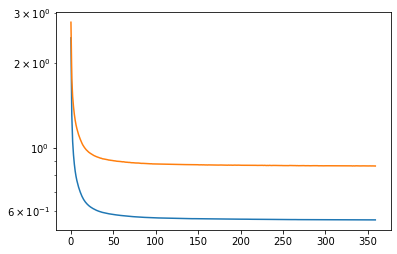

In [45]:
plt.plot(train_losses)
plt.plot(dev_losses)
plt.yscale('log')

In [ ]:
# %%time

# param_grid = ParameterGrid({
#     'batch_size': [2**7, 2**10, 2**12, 2**14],
#     'lr': [1e-4, 1e-3, 1e-2, 1e-1]
# })

# records = []
# for params in tqdm(param_grid):
#     lm = PhonemeLM(
#         phoneme_to_idx, device='cuda', rnn_type='gru', embedding_dimension=50, hidden_dimension=50,
#          max_epochs=200, early_stopping_rounds=3,
#         **params
#     )
    
#     print('Model Params:', params)
#     train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation)
#     for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
#         record = params.copy()
#         record['epoch'] = epoch
#         record['train_loss'] = train_loss
#         record['dev_loss'] = dev_loss
    
#         records.append(record)

# models_df = pd.DataFrame.from_records(records)

In [ ]:
# models_df.sort_values('train_loss')

In [ ]:
# models_df.sort_values('dev_loss')

In [ ]:
g = models_df.groupby(['batch_size', 'lr'])

columns = 3
rows = int(math.ceil(len(g) / columns))
fig, axs = plt.subplots(rows, columns, figsize=(20, 10), sharey=True)
for idx, ((embedding_dimension, rnn_hidden_dimension), t) in enumerate(g):
    row, column = divmod(idx, columns)
    ax = axs[row][column]
    t.set_index('epoch').dev_loss.plot(ax=ax)
    t.set_index('epoch').train_loss.plot(ax=ax)
    ax.set_title(f'batch_size={embedding_dimension}, lr={rnn_hidden_dimension}')
    plt.tight_layout()
    plt.yscale('log')

In [ ]:
print(models_df.batch_size.unique())
print(models_df.lr.unique())

In [ ]:
models_df[models_df.batch_size==16384].sort_values('train_loss')

In [ ]:
def plot(df, batch_size, lr):
    t = models_df[(models_df.batch_size==batch_size) & (models_df.lr==lr)].set_index('epoch')
    t.train_loss.plot()
    t.dev_loss.plot()
plot(df, 1024, .1)

In [ ]:
# 63 minutes for 16 models. 4 minutes each

In [ ]:
# %%time

# param_grid = ParameterGrid({
#     'rnn_type': ['gru'],
#     'embedding_dimension': [10, 50, 100, 200],
#     'rnn_hidden_dimension': [50, 100, 200, 400],
# })

# records = []
# for params in tqdm(param_grid):
#     lm = PhonemeLM(phoneme_to_idx, device='cuda', batch_size=1024,  max_epochs=200, **params)
#     print('Model Params:', params)
#     train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=10)
#     for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
#         record = params.copy()
#         record['epoch'] = epoch
#         record['train_loss'] = train_loss
#         record['dev_loss'] = dev_loss
    
#         records.append(record)

# models_df = pd.DataFrame.from_records(records)

In [ ]:
models_df.embedding_dimension.unique()

In [ ]:
models_df = pd.DataFrame.from_records(records)
models_df.sort_values('dev_loss')
t = models_df[(models_df.embedding_dimension==10) & (models_df.rnn_hidden_dimension==200)]
t.set_index('epoch').train_loss.plot()
t.set_index('epoch').dev_loss.plot()

In [ ]:
# %%time

# param_grid = ParameterGrid({
#     'rnn_type': ['gru'],
#     'embedding_dimension': [10, 100, 400],
#     'rnn_hidden_dimension': [50, 200, 400],
# })

# records = []
# for params in tqdm(param_grid):
#     lm = PhonemeLM(phoneme_to_idx, device='cuda', batch_size=1024,  max_epochs=200, **params)
#     print('Model Params:', params)
#     train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=3)
#     for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
#         record = params.copy()
#         record['epoch'] = epoch
#         record['train_loss'] = train_loss
#         record['dev_loss'] = dev_loss
    
#         records.append(record)

# models_df = pd.DataFrame.from_records(records)

In [ ]:
models_df = pd.DataFrame.from_records(records)

In [ ]:
len(models_df)

In [ ]:
models_df.sort_values('train_loss')

In [ ]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cpu',
    rnn_type='gru', embedding_dimension=10, rnn_hidden_dimension=20,
    max_epochs=10
)

lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=10)

In [ ]:
%%time

lm.fit(train_df.pronunciation, dev_df.pronunciation, max_epochs=5, early_stopping_rounds=5)

In [ ]:
lm = torch.load('lm_1.pt', map_location=torch.device('cpu'))
lm.device = torch.device('cpu')

## Probability of Real Words ##

In [ ]:
%%time

df['probability'] = df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

In [ ]:
df.sort_values('probability', ascending=False, inplace=True)
df.probability.hist(bins=10)

In [ ]:
ta = train_df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))
da = dev_df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

In [ ]:
ta.mean(), da.mean()

In [ ]:
ta.describe()

In [ ]:
da.describe()

In [ ]:
df[df.length == 3]

In [35]:
lm = lm8

### Comparing Multiple Pronunciations ###

In [ ]:
df[df.word == 'with'].sort_values('probability', ascending=False)

In [ ]:
df[df.word == 'tomato'].sort_values('probability', ascending=False)

In [ ]:
df[df.word=='pajamas'].sort_values('probability', ascending=False)

In [ ]:
df[df.word == 'february'].sort_values('probability', ascending=False)

In [ ]:
df.word.value_counts()

In [ ]:
lm.calculate_probability(['P', 'R', 'IH1', 'F', 'S'])

In [ ]:
lm.calculate_probability(['P', 'R', 'IH1', 'F'])

In [ ]:
lm.calculate_probability(['S', 'T', 'R', 'UW1', 'Z'])

### GENERATE PRONUNCIATIONS ###

In [46]:
for _ in range(10):
    pronunciation = lm.generate(100, temperature=None)
    pronunciation_string = ' '.join(pronunciation)
    matches = df[df.pronunciation_string == pronunciation_string]
    
    print(pronunciation_string)
    if len(matches) > 0:
        print('\t', matches.iloc[0]['word'], len(matches), 'total')
    print()

W AO1 R D R W IH2 L K W ER0 Z

TH IH1 SH T L AY2 Z AH0 S

K AO1 R L Z

T IY1 M AY2 T

S P EH2 R IY0 IY1

S EH0 N CH AE1 N AH0 M

M IY1 M AH0 N

K AA1 S AH0 T ER0 EY2 T

OW1 W AA0 N

K OW1 N T W IY0



### Probability of Next ###

In [36]:
pronunciation = ['CH', 'EH0', 'N', 'V', 'AY2', 'R', 'AH0', 'N', 'M', 'EH1', 'N', 'T', 'AH0', 'L', 'IH2']
# pronunciation = ['M', 'EH1', 'N', 'T', 'AH0', 'L', 'IH2']
# pronunciation = ['S', 'EH1', 'N', 'T', 'AH0', 'L', 'IH2']
pronunciation = ['F', 'EH1', 'B', 'Y', 'AH0']


next_probs = lm.next_probabilities(pronunciation)

for phoneme, probability in sorted(next_probs.items(), key=lambda p: -p[1]):
    print(f'[{probability:.4f}] {phoneme}')

[0.5669] L
[0.1957] </W>
[0.1639] N
[0.0136] R
[0.0104] AH0
[0.0100] T
[0.0099] M
[0.0046] ER0
[0.0034] Z
[0.0034] W
[0.0032] S
[0.0021] P
[0.0018] B
[0.0018] K
[0.0017] OW0
[0.0007] F
[0.0007] AW2
[0.0005] AO2
[0.0005] Y
[0.0004] AA0
[0.0004] AA2
[0.0004] OW2
[0.0004] UW0
[0.0003] G
[0.0002] UW2
[0.0002] EH0
[0.0002] IH0
[0.0002] V
[0.0002] IY0
[0.0002] EY2
[0.0002] TH
[0.0002] EH2
[0.0001] D
[0.0001] AO0
[0.0001] CH
[0.0001] <PAD>
[0.0001] HH
[0.0001] ER2
[0.0001] AE0
[0.0001] ZH
[0.0001] EY0
[0.0001] AE2
[0.0001] NG
[0.0001] DH
[0.0001] AH2
[0.0001] UH0
[0.0000] JH
[0.0000] IH2
[0.0000] AA1
[0.0000] UW
[0.0000] UH2
[0.0000] SH
[0.0000] AW0
[0.0000] UW1
[0.0000] EH1
[0.0000] IY1
[0.0000] <W>
[0.0000] EY1
[0.0000] OW1
[0.0000] AY0
[0.0000] IY2
[0.0000] OY2
[0.0000] AE1
[0.0000] OY0
[0.0000] AY2
[0.0000] AO1
[0.0000] UH1
[0.0000] IH1
[0.0000] ER1
[0.0000] AH1
[0.0000] AY1
[0.0000] AW1
[0.0000] OY1


In [ ]:
def probability_next(lm, pronunciation):
    

In [ ]:
lm.calculate_probability(['S'])

In [ ]:
encode_pronunciation(['S'], lm.phoneme_to_idx)

In [ ]:
lm

In [ ]:
torch.save(lm, 'lm.pt')

### Play with Embeddings ###

In [37]:
def most_similar_phonemes(lm, embedding, topn=10):
    other_to_sim = {
        phoneme: cosine_similarity(lm.embedding_for(phoneme), embedding).item()
        for phoneme in phoneme_to_idx

    }

    for other_phoneme, similarity in sorted(other_to_sim.items(), key=lambda p: -p[1])[:topn]:
        print(f'[{similarity:.3f}]\t{other_phoneme}')
        
most_similar_phonemes(lm, lm.embedding_for('DH'))

[1.000]	DH
[0.291]	EY0
[0.222]	V
[0.196]	D
[0.181]	OW0
[0.154]	N
[0.140]	OY2
[0.137]	K
[0.124]	UH1
[0.123]	CH


In [38]:
embeddings = lm.embeddings
# embeddings = lm.embedding.weight.cpu().detach().numpy()
normed_embeddings = normalize(embeddings)

num_clusters = 15
kmeans = KMeans(num_clusters)
kmeans.fit(normed_embeddings)

grouped = defaultdict(set)
for idx, label in enumerate(kmeans.labels_):
    phoneme = lm.vocab[idx]
    grouped[label].add(phoneme)
grouped

defaultdict(set,
            {8: {'<PAD>', 'L', 'NG', 'T'},
             9: {'<W>', 'ER1', 'OW1'},
             12: {'</W>', 'AA1', 'AO1', 'IH1', 'IY1', 'UH1', 'UH2'},
             2: {'AH0', 'AH2', 'AO0', 'AY2', 'EH2', 'IH2', 'UW0'},
             1: {'AE0', 'AE1', 'AE2', 'AH1', 'AW1', 'EH1', 'EY1'},
             14: {'DH', 'F', 'JH', 'N', 'R', 'V', 'Y'},
             0: {'P'},
             7: {'B', 'EY0', 'OW0', 'S'},
             4: {'ER0', 'OW2', 'UW1'},
             3: {'G', 'IY0', 'K', 'M', 'UH0', 'UW'},
             11: {'AW2', 'AY1', 'EH0', 'OY0', 'OY1', 'UW2'},
             6: {'HH', 'TH', 'W', 'Z'},
             5: {'AA0', 'AA2', 'AO2', 'AY0'},
             13: {'CH', 'D', 'SH', 'ZH'},
             10: {'AW0', 'ER2', 'EY2', 'IH0', 'IY2', 'OY2'}})

In [50]:
# For consonants
# - voicing
# - place: bilabial, dental, alveolar, palatal, velar
# - manner: stop, fricative, nasal

# For vowels
# - front/back
# - closed/open
# - rounding

# General
# - syllabic

# TODO: combine multiple vectors together, e.g. {B, G, V, DH, D} for voiced
voicing = lm.embedding_for('B') - lm.embedding_for('P')
forwarding = lm.embedding_for('P') - lm.embedding_for('K')
frication = lm.embedding_for('F') - lm.embedding_for('P')

# new = lm.embedding_for('TH') + voicing
new = lm.embedding_for('K') + voicing
# new = lm.embedding_for('T') + frication
# new = lm.embedding_for('G') + forwarding

phoneme_to_sim = {}
for phoneme in phoneme_to_idx:
    this_embs = lm.embedding_for(phoneme)
    sim = cosine_similarity(new, this_embs).item()
    phoneme_to_sim[phoneme] = sim

sorted(phoneme_to_sim.items(), key=lambda p: -p[1])[:10]

[('K', 0.8372291922569275),
 ('ZH', 0.746835470199585),
 ('B', 0.7381162643432617),
 ('P', 0.6978335976600647),
 ('G', 0.6660592555999756),
 ('T', 0.5788809061050415),
 ('F', 0.5702935457229614),
 ('SH', 0.5514903664588928),
 ('HH', 0.5419299602508545),
 ('CH', 0.5155280232429504)]

In [39]:
import numpy as np
# np.mean([embedding_for('B'), embedding_for('V')], axis=0)
voiced = np.mean([lm.embedding_for(phoneme) for phoneme in ['B', 'V', 'G', 'Z', 'ZH', 'DH', 'JH']], axis=0)
voiceless = np.mean([lm.embedding_for(phoneme) for phoneme in ['P', 'F', 'K', 'S', 'SH', 'TH', 'CH']], axis=0)
voicing = voiced - voiceless
most_similar_phonemes(lm, voicing + lm.embedding_for('S'))

[0.839]	S
[0.375]	DH
[0.265]	V
[0.255]	B
[0.254]	JH
[0.236]	OW0
[0.199]	Z
[0.192]	EY0
[0.180]	UW2
[0.177]	ZH


In [ ]:
most_similar_phonemes(lm, voicing)

In [ ]:
from phoneme_lm import START, END, PAD
def analogy(lm, a, b, c):
    """
    a - b = c - w
    argmax(w) over sim(w, c - a + b)
    """
    emb_a = lm.embedding_for(a)
    emb_b = lm.embedding_for(b)
    emb_c = lm.embedding_for(c)
    
    all_phonemes = set(lm.vocab) - {START, END, PAD}
    
    phoneme_to_sim = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb_p = lm.embedding_for(phoneme)
        sim = cosine_similarity(emb_p, emb_c - emb_a + emb_b)
        phoneme_to_sim[phoneme] = sim.item()
    return phoneme_to_sim

analogies = analogy(lm, 'P', 'K', 'B')
for phoneme, sim in sorted(analogies.items(), key=lambda p: -p[1]):
    print(f'[{sim:.4f}] {phoneme}')


In [ ]:
from phoneme_lm import START
phoneme_idx = lm.phoneme_to_idx[START]

In [ ]:
output, hidden_state = lm(torch.LongTensor([phoneme_idx]).unsqueeze(0))

In [ ]:
hidden_state.shape

In [ ]:
hidden = torch.zeros(1, 1, 10)

lm(torch.LongTensor([phoneme_idx]).unsqueeze(0), hidden)